In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
from scipy.integrate import odeint
from multiprocessing import Pool
import time

## 1. Lorenz System Generator

In [2]:
def f(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

In [3]:
def benchmarkData():
    #timestep = 0.01  # typical time difference mentioned in Shimada&Nagashima(1979)
    timestep = 0.01
    size = 30000

    np.random.seed(42)
    state0 = np.random.uniform(-1,1,(3)).tolist()
    t = np.arange(0.0, timestep*size, timestep)

    pool = Pool(2)
    states = pool.apply(odeint, args=(f, state0, t))
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.gca(projection="3d")
    ax.plot(states[:, 0], states[:, 1], states[:, 2], linewidth=0.3)
    ax.xaxis.set_label_text('x')
    ax.yaxis.set_label_text('y')
    ax.zaxis.set_label_text('z')
    plt.draw()
    plt.show()
    return states, timestep

## 2. Model

### 2.1 Knowledge-based Model

In [4]:
class KnowledgeModel:
    def __init__(self, phaseLen, a, b, c, error, timestep):
        self.a = a
        self.b = b
        self.c = c
        self.epsilon = error
        self.dt = timestep
        self.state = np.zeros((phaseLen[0] + phaseLen[1] + phaseLen[2] + 1, 3))
        self.current = 0

    def update(self, prev, partitition=1.):
        self.state[self.current][0] = prev[0] + (prev[1]-prev[0])*self.a*(self.dt/partitition)
        self.state[self.current][1] = prev[1] + (prev[0]*((self.b+self.epsilon)-prev[2])-prev[1])*(self.dt/partitition)
        self.state[self.current][2] = prev[2] + (prev[0]*prev[1]-self.c*prev[2])*(self.dt/partitition)

    def getState(self, t):
        return self.state[self.current]
        self.current += 1

### 2.2 ESN and Hybrid Model

In [5]:
class Model:
    def __init__(self, knowledgeParam=dict(), ESNParam=dict(), phaseLen=[], hybrid=True, seed=0):
        np.random.seed(seed)
        #setting and hyperparams
        self.initLen = phaseLen[0] # washout phase
        self.trainLen = phaseLen[1]
        self.testLen = phaseLen[2]
        self.rho = ESNParam['rho'] # spectral radius
        self.sigma = ESNParam['sigma'] # input scale
        self.lamda = ESNParam['lamda'] # coefficient of regularization
        self.inSize = ESNParam['inSize']
        self.resSize = ESNParam['resSize']
        self.outSize = ESNParam['outSize']
        self.hybrid = hybrid

        #model
        self.KM = KnowledgeModel(phaseLen, **knowledgeParam) if self.hybrid else None
        self.Win = (np.random.rand(self.resSize,1 + self.inSize + self.hybrid * self.inSize) - 0.5) * 2 * self.sigma
        self.W = np.random.rand(self.resSize, self.resSize) - 0.5
        self.W = self.W/max(abs(linalg.eig(self.W)[0]))*self.rho
        self.Wout =  np.zeros((self.resSize, 1 + self.inSize + self.resSize + 2 * self.hybrid*self.inSize))
    
    def fit(self, u, y, partition=1.):
        time1 = 0
        time2 = 0
        x = np.zeros((self.resSize, 1))
        X = np.zeros((1 + 2 * self.hybrid * self.inSize + self.resSize, self.trainLen)) 
        Yt = y[None, self.initLen:self.trainLen+self.initLen].squeeze().T

        for t in range(self.trainLen+self.initLen):
            ut = u[t].reshape(-1,1)
            if self.hybrid:
                temp = time.time()
                for i in range(int(partition)): self.KM.update(ut, partition)
                kt = self.KM.getState(t).reshape(-1,1)
                temp = time.time() - temp
                time1 = (t*time1 + temp) / float(t+1)

                temp = time.time()
                x = np.tanh(np.dot(self.Win, np.vstack((1, ut, kt))) + np.dot(self.W, x))
                temp = time.time() - temp
                time2 = (t*time2 + temp) / float(t+1)

                if t >= self.initLen:
                    X[:, t-self.initLen] = np.vstack((1, ut, kt, x))[:, 0].reshape(self.resSize+2*self.inSize+1)
            else:
                x = np.tanh(np.dot(self.Win, np.vstack((1, ut))) + np.dot(self.W, x))
                if t >= self.initLen:
                    X[:, t-self.initLen] = np.vstack((1, x))[:, 0].reshape(self.resSize+1)
        
        self.Wout = np.dot(np.dot(Yt,X.T), linalg.inv(np.dot(X,X.T) + self.lamda*np.eye(1 + 2 * self.hybrid*self.inSize + self.resSize)))

        return time1, time2
    
    def predict(self, u, partition=1.):
        time1 = 0
        time2 = 0
        x = np.zeros((self.resSize, 1))
        Y = np.zeros((self.outSize, self.testLen))
        ut = u[self.trainLen+self.initLen-1].reshape(-1,1)
        for t in range(self.testLen):
            if self.hybrid:
                temp = time.time()
                for i in range(int(partition)): self.KM.update(ut, partition)
                kt = self.KM.getState(self.trainLen+self.initLen+t).reshape(-1,1)
                temp = time.time() - temp
                time1 = (t*time1 + temp) / float(t+1)

                temp = time.time()

                x = np.tanh(np.dot(self.Win, np.vstack((1, ut, kt))) + np.dot(self.W, x))
                temp = time.time() - temp
                time2 = (t*time1 + temp) / float(t+1)

                Y[:, t] = np.dot(self.Wout, np.vstack((1, ut, kt, x))).squeeze()
            else:
                x = np.tanh(np.dot(self.Win, np.vstack((1, ut))) + np.dot(self.W, x))
                Y[:, t] = np.dot(self.Wout, np.vstack((1, x))).squeeze()
            ut = Y[:, t].reshape(-1,1) # closed loop
        return Y

    def getError(self, y, Y):
        errorLen = self.testLen
        gt = y[self.trainLen+self.initLen+1:self.trainLen+self.initLen+errorLen+1]
        pred = Y[:, 0:errorLen].T
        THRESHOLD = 30
        for i in range(errorLen):
            # print(i, linalg.norm(gt[i]-pred[i]))
            # print(gt[i], pred[i])
            if linalg.norm(gt[i]-pred[i]) > THRESHOLD: return i
        return errorLen
        # nmse = sum(np.square(gt - pred.T)) / errorLen / np.std(gt) / np.std(gt)
        # return nmse
    
    def visualize(self, y, Y):
        for i in range(self.inSize):
            plt.figure(1).clear()
            plt.plot(y[self.trainLen+self.initLen+1:self.trainLen+self.initLen+self.testLen+1, i], 'g')
            plt.plot(Y.T[:, i], 'b')
            plt.title('Target and generated signals')
            plt.legend(['Target signal', 'Free-running predicted signal'])
            plt.show()

## 3. Performance Comparison

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  del sys.path[0]


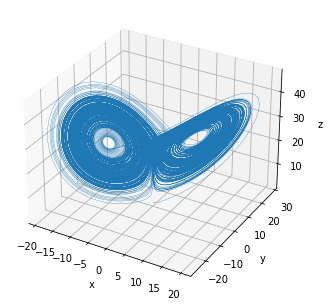

In [6]:
# load the data
knowledge_timestep = 0.1
data, generator_timestep = benchmarkData()
data = data[::int(knowledge_timestep/generator_timestep)]
u = data[:, :] # input
y = data[1:, :] # output

### 3.1 Hybrid Model

In [ ]:
sizes = [100*(i+1) for i in range(20)]
partitions = [i+1 for i in range(10)]
result = dict()
for size in sizes:
    for partition in partitions:
        knowledgeParam = dict(
            a = 28.0,
            b = 10.0,
            c = 8.0/3.0,
            error = 0.5,
            timestep = knowledge_timestep,
        )

        ESNParam = dict(
            rho = 0.9,
            sigma = 0.5,
            lamda = 1e-7,
            inSize = 3,
            resSize = size,
            outSize = 3,
        )
        model = Model(knowledgeParam, ESNParam, phaseLen=(100,2000,100), hybrid=True, seed=69566854)
        timeKM, timeESN = model.fit(u,y, partition)
        Y = model.predict(u, partition)
        # model.visualize(y, Y)
        # print(model.getError(y, Y))
        result[(size, partition)] = [model.getError(y, Y), timeKM, timeESN]
        print(size, partition, result[(size, partition)])
# model.visualize(y, Y)

100 1 [50, 4.07223474411738e-05, 8.455548967633925e-05]
100 2 [50, 7.565611884707497e-05, 0.00010519765672229588]
100 3 [50, 0.00010821206229073659, 0.00010697523752848307]
100 4 [49, 0.00015938724790300648, 0.00014728216897873635]


In [ ]:
valtime = []
time_KM = []
time_ESN = []
for size in sizes:
    for partition in partitions:
        # errorx.append(result[(size, partition)][0][0])
        # errory.append(result[(size, partition)][0][1])
        # errorz.append(result[(size, partition)][0][2])
        valtime.append(result[(size, partition)][0])
        time_KM.append(result[(size, partition)][1])
        time_ESN.append(result[(size, partition)][2])
proportion = np.array(time_KM)/np.array(time_ESN)

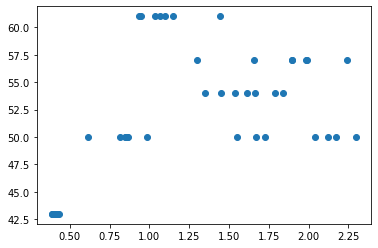

In [ ]:
plt.figure(1).clear()
plt.scatter(proportion, valtime)
# plt.plot(error1, 'r')
# plt.plot(error2, 'g')
# plt.plot(error3, 'b')
# x = [i for i in range(proportion.shape[0])]
# plt.xticks(x, proportion)
# plt.title('Target and generated signals')
# plt.legend(['Target signal', 'Free-running predicted signal'])
# plt.show()

### 3.2 ESN only

In [ ]:
# model2 = Model(knowledgeParam, ESNParam, phaseLen=(100,1000,100), hybrid=False, seed=0)
# model2.fit(u,y)
# Y = model2.predict(u)
# print(model2.getError(y, Y))
# model2.visualize(y, Y)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2728d440-5ff4-4e65-a400-4cda139b052c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>